## Библиотеки

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [42]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpl_img
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import copy

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models

torch.cuda.empty_cache()

from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

In [4]:
def define_paths(root_dir, num_pics):
    dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    filepaths = []
    labels = []
    num_pics_dir = 0
    print_num_pics = []
    for dir in tqdm(dirs):
        dir_path = os.path.join(root_dir, dir)
        if not os.listdir(dir_path):
            continue

        dirs_in_dir = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        if len(dirs_in_dir) != 0:
            num_pics_dir = num_pics // len(dirs_in_dir)
        else:
            num_pics_dir = num_pics
        print_num_pics.append(num_pics_dir)

        for d in dirs_in_dir:
            d_path = os.path.join(dir_path, d)
            if not os.listdir(d_path):
                continue

            for i, filename in enumerate(os.listdir(d_path)):
                if i >= num_pics_dir:
                    break
                file_path = os.path.join(d_path, filename)
                filepaths.append(file_path)
                labels.append(dir)

        for i, filename in enumerate(os.listdir(dir_path)):
            if i >= num_pics:
                break
            file_path = os.path.join(dir_path, filename)
            if not os.path.isdir(file_path):
                filepaths.append(file_path)
                labels.append(dir)

    print()
    return filepaths, labels

def define_dataframe(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_dataframe(data_dir, num_pic):
    files, classes = define_paths(data_dir, num_pic)
    df = define_dataframe(files, classes)
    return df

In [5]:
data_dir = '/content/drive/MyDrive/Degree/bone_marrow_cell_dataset'
num_pics = 500

df = create_dataframe(data_dir, num_pics)

categories = list(df.groupby('labels').count().index)
replace_dict = {key: value for value, key in enumerate(categories)}
reverse_dict = {key: value for key, value in enumerate(categories)}

print(df.shape)
df.groupby('labels').count()

100%|██████████| 22/22 [04:22<00:00, 11.91s/it]


(8035, 2)


,filepaths
labels,
ABE,8
ART,500
BAS,441
BLA,492
EBO,476
EOS,498
FGC,47
HAC,409
KSC,42


In [6]:
df.describe()

,filepaths,labels
count,8035,8035
unique,8035,21
top,/content/drive/MyDrive/Degree/bone_marrow_cell...,ART
freq,1,500


In [7]:
strat = df['labels']
train_df_imbalance, test_df = train_test_split(df,
    train_size = 0.9,
    shuffle = True,
    random_state = 42,
    stratify = strat
)

In [8]:
df_minor = train_df_imbalance[
    (train_df_imbalance.labels == 'FGC') |
    (train_df_imbalance.labels == 'KSC') |
    (train_df_imbalance.labels == 'LYI')
]
df_major = train_df_imbalance[
    (train_df_imbalance.labels != 'FGC') &
    (train_df_imbalance.labels != 'KSC') &
    (train_df_imbalance.labels != 'LYI')
]

upsample_num = int(num_pics * 1.5)
df_minor_up = resample(
    df_minor,
    replace = True,
    n_samples = upsample_num,
    random_state = 42
)

df_no_ABE = pd.concat([df_major, df_minor_up])

In [9]:
df_minor = df_no_ABE[df_no_ABE.labels == 'ABE']
df_major = df_no_ABE[df_no_ABE.labels != 'ABE']

upsample_num = num_pics // 5
df_minor_up = resample(
    df_minor,
    replace = True,
    n_samples = upsample_num,
    random_state = 42
)

train_df = pd.concat([df_major, df_minor_up])

In [10]:
print(train_df.shape)
train_df.groupby('labels').count()

(7935, 2)


,filepaths
labels,
ABE,100
ART,450
BAS,397
BLA,443
EBO,428
EOS,448
FGC,229
HAC,368
KSC,204


In [11]:
train_df['labels'].replace(replace_dict, inplace=True);
test_df['labels'].replace(replace_dict, inplace=True);

In [12]:
class ImageData(Dataset):
    def __init__(self, df, transform):
        super().__init__()
        self.df = df
        self.image_paths = self.df.filepaths.tolist()
        self.classes = self.df.labels.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.classes[index]
        img_path = self.image_paths[index]
        image = plt.imread(img_path)[:,:,:3]
        image = self.transform(image)
        return image, label

In [13]:
BATCH_SIZE = 20
image_side = 224
image_size = (image_side, image_side)

channels = 3
class_count = len(categories)

In [14]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_side),
    transforms.ToTensor()
])
train_data = ImageData(df = train_df, transform = train_transform)
train_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [73]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_side),
    transforms.ToTensor()
])
test_data = ImageData(df = test_df, transform = test_transform)
test_loader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def show_images(data_loader, model=None):
    images, labels = next(iter(data_loader))
    plt.figure(figsize = (20, 20))
    length = len(labels)
    sample = min(length, 16)

    if model != None:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i].float()
        image = image.permute(1, 2, 0)
        plt.imshow(image.cpu())

        if model == None:
            plt.title(
                reverse_dict[labels[i].item()],
                color='blue',
                fontsize=12
            )
        else:
            if predictions[i] == labels[i]:
                title_color = 'green'
            else:
                title_color = 'red'
            plt.title(
                f'Predicted: {reverse_dict[predictions[i].item()]} | True: {reverse_dict[labels[i].item()]}',
                color=title_color,
                fontsize=12
            )
        plt.axis('off')
    plt.show()

In [18]:
show_images(train_loader);

Output hidden; open in https://colab.research.google.com to view.

## EfficientNet

In [19]:
# Create pre-trained model
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

model = models.efficientnet_b5(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features
model._fc = nn.Identity()

model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features=num_features),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, class_count)
)

# Define optimizer and loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

# Print model summary
#print(summary(model, (channels, image_side, image_side), device='cuda'))
class_count

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 82.4MB/s]


21

In [20]:
training_history = {'accuracy': [], 'loss':[] }
test_history = {'accuracy': [], 'loss': []}

In [21]:
def plot_accuracy_loss():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(training_history['loss'], label='Train Loss')
    #axs[0].plot(test_history['loss'], label='Test Loss')
    axs[0].set_title("Losses over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(training_history['accuracy'], label='Train Accuracy')
    #axs[1].plot(test_history['accuracy'], label='Test Accuracy')
    axs[1].set_title("Accuracies over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()

In [22]:
def train(model, criterion, optimizer, num_epochs, num_val_frequency):
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        epoch_accuracy = 0.0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                predicted_outputs = model(inputs)
                loss = criterion(predicted_outputs, labels)
                loss.backward()
                optimizer.step()

        if epoch % num_val_frequency == 0 or epoch == num_epochs:
            model.eval()

            for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    predicted_outputs = model(inputs)
                    _, predictions = torch.max(predicted_outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                epoch_accuracy += accuracy_score(
                                    y_true=labels.cpu().numpy(),
                                    y_pred=predictions.cpu().numpy()
                                )

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy /= len(train_loader)

            print()
            print('Epoch {}/{}:     Accuracy: {:.4f}    Loss: {:.4f}'.format(
                epoch, num_epochs, epoch_accuracy, epoch_loss
            ))

            training_history['loss'].append(epoch_loss)
            training_history['accuracy'].append(epoch_accuracy)

In [70]:
def evaluate(model):
    test_loss = 0.0
    test_accuracy = 0
    matrix = np.zeros((class_count, class_count))

    model.eval()

    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predicted_outputs = model(inputs)
            loss = criterion(predicted_outputs, labels)

        _, predictions = torch.max(predicted_outputs, 1)
        test_loss += loss.item() * inputs.size(0)

        test_accuracy += accuracy_score(
            y_true=labels.cpu().numpy(),
            y_pred=predictions.cpu().numpy()
        )

        matrix += confusion_matrix(
            y_true=[reverse_dict[i] for i in labels.cpu().numpy()],
            y_pred=[reverse_dict[i] for i in predictions.cpu().numpy()],
            labels=categories
        )

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

    print()
    print('Accuracy: {:.4f}    Loss: {:.4f}'.format(
        test_accuracy, test_loss
    ))

    fig, ax = plt.subplots(figsize=(12, 9))
    ConfusionMatrixDisplay(matrix, display_labels=categories).plot(ax=ax);

In [31]:
save_weights = False
num_epochs = 12
num_val_frequency = 4

if save_weights:
    train(model, criterion, optimizer, num_epochs, num_val_frequency)
    torch.save(model.state_dict(), '/content/drive/MyDrive/Degree/weights.pth')
else:
    model.load_state_dict(torch.load('/content/drive/MyDrive/Degree/weights.pth', map_location=torch.device(device)))

100%|██████████| 41/41 [03:55<00:00,  5.75s/it]



Accuracy: 0.5634    Loss: 32.0915


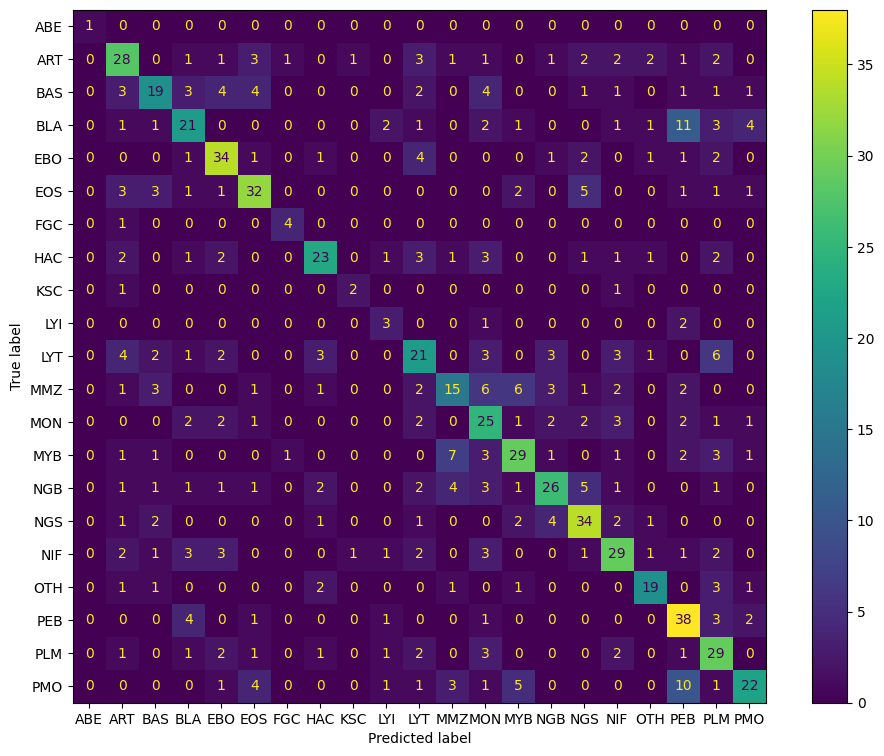

In [74]:
evaluate(model)

In [75]:
show_images(test_loader, model)

Output hidden; open in https://colab.research.google.com to view.